In [1]:
import sys
sys.path.append("../")

In [6]:
%load_ext autoreload
%autoreload 2
import os
import hashlib
import numpy as np
import traceback
from common.dataloader import load_dataset
from matplotlib import pyplot as plt

In [7]:
def onehot2interval(arr):
    result = []
    record = False
    for idx, item in enumerate(arr):
        if item == 1 and not record:
            start = idx
            record = True
        if item == 0 and record:
            end = idx  # not include the end point, like [a,b)
            record = False
            result.append((start, end))
    return result

In [8]:
def running_mean(x, N):
    cumsum = np.cumsum(np.insert(x, 0, 0)) 
    return (cumsum[N:] - cumsum[:-N]) / N

# def MA(x, N):
#     def running_mean(x, N):
#         cumsum = np.cumsum(np.insert(x, 0, 0)) 
#         return (cumsum[N:] - cumsum[:-N]) / N
#     res = []
#     for col in range(x.shape[1]):
#         res.append(running_mean(x[:, col], N))
#     return np.vstack(res)

In [9]:

dataset = "HUAWEI_FILTERED" # change to HUAWEI
# subdatasets =["c91f4a07", "ca2ae31d", "f7958fb7"] # Change to skipped hashid list
subdatasets =["ca2ae31d",] # Change to skipped hashid list
outdir = f"./{dataset}_figures_casestudy_filtered"
key = "test"
chunk_size = 50


#     "HUAWEI_GROUP_A": ["e29ca1cd",
#                        "c23b2b2d",
#                        "aeb5a1de",
#                        "2fe95315",
#                        "0a82a873",
#                        "af732cc4"],

for subdataset in subdatasets:
    current_out = os.path.join(outdir,subdataset) 
    os.makedirs(current_out, exist_ok=True)
    data_dict = load_dataset(dataset, subdataset, "all", root_dir="../")
    
    # data_dict[key] = data_dict[key][:, [3,21,24,26,32,38]]
    data_dict[key] = data_dict[key][:, [3,21,24,32]]
    # data_dict[key] = data_dict[key][:, [6,7,10,15,21,29]]

    dataToPlot = []
    intervalToPlot = []
    
    dims = list(range(data_dict[key].shape[1]))
    for cidx, chunk in enumerate(np.array_split(dims, 1 + len(dims)//chunk_size)):
        fig, ax = plt.subplots(len(chunk), figsize=(15, 4*len(chunk)))
        for idx, dim_idx in enumerate(chunk):
            data = data_dict[key][:, dim_idx]
            data = running_mean(data, 5)
            
            dataToPlot.append(data)

            if key == "test":
                label = data_dict["test_labels"]
                intervals = onehot2interval(label)

                intervalToPlot.append(intervals)

                ax[idx].plot(data, label=f"{subdataset} : {dim_idx}")
                for s,e in intervals:
                    ax[idx].axvspan(s, e, alpha=0.2, color='red')
                ax[idx].legend()
        fig.savefig(os.path.join(current_out, f"chunk_{cidx}.pdf"))
        plt.close()
    print(f"Finish plotting {subdataset}")
    pass

Loading ca2ae31d of HUAWEI_FILTERED dataset
.././datasets/anomaly/HUAWEI_FILTERED/ca2ae31d_train.pkl
Shape of train is (718, 43).
Shape of test is (718, 43).
Shape of test_labels is (719, 1).
Finish plotting ca2ae31d


In [10]:

import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import datetime
from datetime import timedelta
from random import randrange

plt.rcParams['font.sans-serif']=['Times New Roman'] # 用来正常显示中文标签
plt.rcParams['font.serif']=['Times New Roman'] # 用来正常显示中文标签
# plt.rcParams['axes.unicode_minus']=False # 用来正常显示负号
plt.rcParams['legend.loc']='upper left' 

linewidth = 4
fontSize = 40
fontLegend = {'family' : 'Times New Roman',
         'weight' : 'semibold',
         'size'   : fontSize - 5
}
fontLabel = {'family' : 'Times New Roman',
         'weight' : 'semibold',
         'size'   : fontSize
}
fontAxis = {'family' : 'Times New Roman',
         'weight' : 'semibold',
         'size'   : fontSize
}

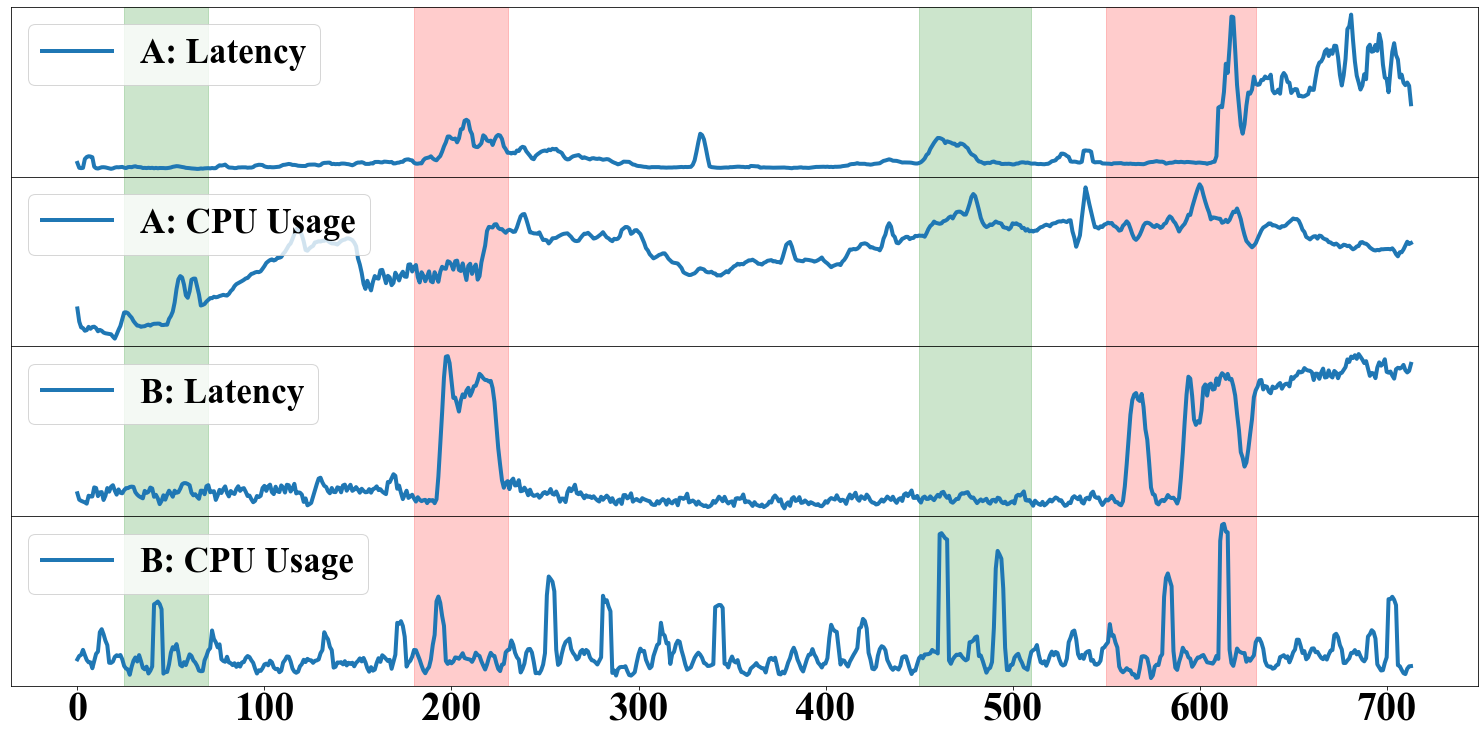

In [16]:

height = 13
figsize = (1.618 * height, 10)
fig, ax = plt.subplots(len(dataToPlot), figsize = figsize)
fig.tight_layout()#调整整体空白
plt.subplots_adjust(wspace =0, hspace =0)#调整子图间距

redIntervalToPlot = [(180, 230), (550, 630)]
greenIntervalToPlot = [(25, 70), (450, 510)]

labelMap = {
    1: "A: CPU Usage",
    0: "A: Latency",
    3: "B: CPU Usage",
    2: "B: Latency"
}

for axId in range(len(dataToPlot)):
    ax[axId].plot(dataToPlot[axId], label=labelMap[axId], linewidth=linewidth)
    for s,e in redIntervalToPlot:
        ax[axId].axvspan(s, e, alpha=0.2, color='red')
    for s,e in greenIntervalToPlot:
        ax[axId].axvspan(s, e, alpha=0.2, color='green')

    # ax[axId].set_xticks([])
    ax[axId].set_yticks([])
    # ax[axId].tick_params(axis='y', labelsize=fontSize)
    # ax[axId].set_ylabel("ylabel", fontdict = fontLabel)
    ax[axId].legend(prop=fontLegend, loc='upper left')
    ax[axId].tick_params(axis='x', labelsize=fontSize)

fig.savefig("dependency.pdf", bbox_inches='tight')
